# AURORA, A multi sensor dataset for robotic ocean exploration

This notebook accompanies the dataset and the report _"AURORA, A multi sensor dataset for robotic ocean exploration", by Marco Bernardi, Brett Hosking, Chiara Petrioli, Brian J. Bett, Daniel Jones, Veerle Huvenne, Rachel Marlow, Maaten Furlong, Steve McPhail and Andrea Munafo._

> **Abstract** The current maturity of autonomous underwater vehicles (AUVs) has made their deployment practical and cost-effective, such that many scientific, industrial and military applications now include AUV operations. However, the logistical difficulties and high costs of operating at-sea are still critical limiting factors in further technology development, the benchmarking of new techniques and the reproducibility of research results.
To overcome this problem, we present a freely available dataset suitable to test control, navigation, sensor processing algorithms and others tasks. This dataset combines AUV navigation data, side-scan sonar, multibeam echosounder data and seafloor camera image data, and associated sensor acquisition meta-data to provide a detailed characterisation of surveys carried out by the National Oceanography Centre (NOC) in the Greater Haig Fras Marine Conservazion Zone (MCZ) of the U.K in 2015.


This notebook shows how the dataset is structured, how read the data, and provides simple examples on how to use it.

Only minimal processing is done to the data so that, most of the time, the results are showing the raw data as it was acquired during the mission.


### Dependencies

This notebook depends on the following packages:

- [scipy]() `pip install scipy` 
- [GDAL]() `pip install GDAL`   
- [OpenCV]() `pip install opencv-python`. 
- [Pillow]() `pip install Pillow`
- [pyxtf](https://github.com/oysstu/pyxtf) `pip3 install pyxtf`
- [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/installation.html) `pip install ipyleaflet`
- [pymap3d]() `pip install pymap3d`

The notebook also forks the [pyall](https://github.com/pktrigg/pyall) package.

There is a conda equivalent for some of the packages and you might decide to use that:
- `conda install -c anaconda scipy`
- `conda install -c conda-forge gdal`
- `conda install -c conda-forge ipyleaflet`

You can also create an anaconda environment using the `req.txt` file provided in the `env` diredctory of this repository:

`conda env create --file env/req.txt`

or through the environment file `environment.yml` provided in the same folder:

`conda env create --file env/environment.yml`

To integrate it better with jupyter notebook run the following command:
- `python -m ipykernel install --user --name aurora --display-name="aurora"`

You can now select the correct kernel directly from the Kernel menu.


If your jupyter_client in your environment is <5.3 then you might need to activate the ipyleaflet environment. You can do so, running:

`jupyter nbextension enable --py --sys-prefix ipyleaflet`


**Note for Windows users:** 

GDAL core and python binding packages can also be downloaded and installed from [gdal.org](https://gdal.org/).





Import the necessary packages:

In [1]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle, Polyline, LayersControl

from matplotlib import cm
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d

import pandas as pd
import numpy as np
import pathlib as pl
import datetime

import csv
import math
import random

import time
from datetime import datetime
import warnings

import cv2
from pyxtf import xtf_read, concatenate_channel, XTFHeaderType

import utils.geodetic
import utils.pyall as pa
import utils.shaded_relief as sr
from utils.palette import *
from utils.emb import *
from utils.utils import *

In [2]:
%matplotlib notebook

In [3]:
%load_ext autoreload
%autoreload 2

### Select the data folder

This notebook has been set up to run on a subset of the AURORA dataset that is available at [aurora dataset sample](https://github.com/noc-mars/aurora_dataset_sample.git).

The notebook can be also run directly on the full dataset that is available at [aurora-multi-sensor-dataset-robotic-ocean-exploration](https://ieee-dataport.org/open-access/aurora-multi-sensor-dataset-robotic-ocean-exploration) changing the path in the cell below to match the dataset path. If the dataset has been downloaded as provided, it should be sufficient to replace:

`data_folder = pl.Path(r'../aurora_dataset_sample/JC125')`

with

`data_folder = pl.Path(r'../aurora/JC125')`

The rest of the notebook assumes that the dataset sample has been downloaded and saved in this notebook parent's folder (`../`).

In [4]:
data_folder = pl.Path(r'../aurora_dataset_sample/JC125')

print(data_folder.absolute())

/Users/andreamunafo/Downloads/workspace/aurora/../aurora_dataset_sample/JC125


# Experimental area: Haig Fras survey area in the Celtic Sea

In [5]:
haig_fras_p      = (50.35, -7.72%360)
haig_fras_bounds = ( (50.20, -7.52%360), (50.55, -7.92%360) )

In [6]:
map_layer = basemap_to_tiles(basemaps.Esri.NatGeoWorldMap)

m = Map(layers=(map_layer, ), center=haig_fras_p, zoom=7)

rectangle = Rectangle(bounds=haig_fras_bounds, name="haig_fras_bounds")

m.add_layer(rectangle)

control = LayersControl(position='topright')
m.add_control(control)

m

Map(center=[50.35, 352.28], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

If the previous cell did not show a map of the Celtic Sea, you most likely need to run

`jupyter nbextension enable --py --sys-prefix ipyleaflet`

# Characterising the area: sound speed and bathymetry

A Conductivity, Temperature Depth (CTD) file is available in the dataset:
  - M086_CTD.csv
  
It contains CTD values for August 10, and 11, 2015. The table below reports the specific values present in the file:

| Variable Name | Meaning |
|---------------|---------------
|T1 °C    | CTD Temperature 1 |
|T2 °C    | CTD Temperature 2 |
|C1       | CTD Conductivity&1 |
|C2       | CTD Conductivity&2 |
|Depth m  | CTD depth |
|DO V     | CTD – Dissolved oxygen reading |
|LSS V    | CTD – Light scattering sensor reading |
|EH V     | CTD – EH Sensor reading |
|rho1 Kg/m3  | CTD – Calculated density1 using the seabird program |
|rho2 Kg/m3  | CTD – Calculated density2 using the seabird program |


The CTD file can be read using the standard pandas read_csv function:

In [7]:
ctd_file = data_folder/'M86/CTD/M086_CTD.csv'

In [8]:
ctd_df = pd.read_csv(ctd_file, sep=';')

The CTD file does not contain the sound speed values, but these can be calculated from the available data, for example as:

In [9]:
ssp = []
for index, row in ctd_df.iterrows():
    salinity = conductivityToSalinity(C=row['C1'], t=row['T1'], p=kPaToDecibars(depthToPressure(row['Depth']))) 
    sv = soundVelocity(S=salinity, T=row['T1'], P0=kPaToDecibars(depthToPressure(row['Depth']))) 
    ssp.append(sv)

ctd_df['ssp'] = ssp 

ctd_df.head()

eTime            eTimeStart        T1        T2       C1  \
0  10-Aug-2015 16:30:02  10-Aug-2015 16:30:01  0.000185  0.000011  18.0502   
1  10-Aug-2015 16:30:03  10-Aug-2015 16:30:01  0.000186  0.000014  18.0459   
2  10-Aug-2015 16:30:04  10-Aug-2015 16:30:01  0.000199  0.000010  18.0423   
3  10-Aug-2015 16:30:05  10-Aug-2015 16:30:01  0.000201  0.000012  18.0402   
4  10-Aug-2015 16:30:06  10-Aug-2015 16:30:01  0.000196  0.000010  18.0386   

        C2  Depth   DO     LSS        EH      rho1  rho2          ssp  
0  16.4716  1.539  0.0 -1.7590  998.6018  998.8794   0.0  1430.222524  
1  16.4531  1.524  0.0 -1.7591  998.6025  998.8830   0.0  1430.215132  
2  16.4627  1.501  0.0 -1.7593  998.6031  998.8810   0.0  1430.208829  
3  16.4716  1.492  0.0 -1.7593  998.6035  998.8800   0.0  1430.205198  
4  16.4745  1.487  0.0 -1.7594  998.6037  998.8792   0.0  1430.202436

Values can be filtered out using the available timesteps. In the following cells, time is converted to epoch first and then filtered:

In [10]:
epoch_time = eTimeToEpoch(ctd_df['eTime'].values)
ctd_df['epoch'] = epoch_time 

aug_10 = ctd_df['epoch'] < eTimeToEpoch('10-Aug-2015 23:59:59')[0]
aug_11 = ctd_df['epoch'] > eTimeToEpoch('10-Aug-2015 23:59:59')[0]

# and here are the values for August 10, 2015 only
ctd_df[aug_10].head()

eTime            eTimeStart        T1        T2       C1  \
0  10-Aug-2015 16:30:02  10-Aug-2015 16:30:01  0.000185  0.000011  18.0502   
1  10-Aug-2015 16:30:03  10-Aug-2015 16:30:01  0.000186  0.000014  18.0459   
2  10-Aug-2015 16:30:04  10-Aug-2015 16:30:01  0.000199  0.000010  18.0423   
3  10-Aug-2015 16:30:05  10-Aug-2015 16:30:01  0.000201  0.000012  18.0402   
4  10-Aug-2015 16:30:06  10-Aug-2015 16:30:01  0.000196  0.000010  18.0386   

        C2  Depth   DO     LSS        EH      rho1  rho2          ssp  \
0  16.4716  1.539  0.0 -1.7590  998.6018  998.8794   0.0  1430.222524   
1  16.4531  1.524  0.0 -1.7591  998.6025  998.8830   0.0  1430.215132   
2  16.4627  1.501  0.0 -1.7593  998.6031  998.8810   0.0  1430.208829   
3  16.4716  1.492  0.0 -1.7593  998.6035  998.8800   0.0  1430.205198   
4  16.4745  1.487  0.0 -1.7594  998.6037  998.8792   0.0  1430.202436   

          epoch  
0  1.439224e+09  
1  1.439224e+09  
2  1.439224e+09  
3  1.439224e+09  
4  1.439224e+09

<IPython.core.display.Javascript object>


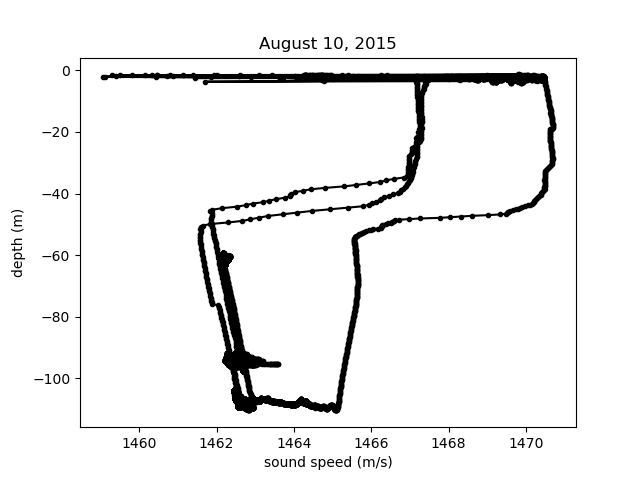

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1)

plt.plot(ctd_df[aug_11]['ssp'], -ctd_df[aug_11]['Depth'], marker='.', color='black')

ax.set_ylabel('depth (m)')
ax.set_xlabel('sound speed (m/s)')
ax.set_title('August 10, 2015');

## Reading MultiBeam Data

The multibeam data can be read in multiple ways:
 - the file 'pointcloud-xyza.xyz' is a csv file that contains the extracted point cloud (x,y,z,amplitude) 
 - reading the raw file (kongsberg `.all` file provided compressed as a zip file)

## Reading the raw multi-beam data

To read the raw multibeam files (.all) we use the [pyall]() open source library.
Please refer to [EM Series Multibeam echo sounders Datagram formats](https://www.kongsberg.com/globalassets/maritime/km-products/product-documents/160692_em_datagram_formats.pdf) for more information.

In [12]:
ems = Emb(data_folder/'M86/multibeam_echosounder/raw/M0860005.all')

In [13]:
ems.read_datagrams()

INFO:utils.emb:Start reading file: ../aurora_dataset_sample/JC125/M86/multibeam_echosounder/raw/M0860005.all
INFO:utils.emb:File ../aurora_dataset_sample/JC125/M86/multibeam_echosounder/raw/M0860005.all read correctly.


We can now plot the read datagrams as a waterfall image. Note that no processing is done and that only the raw depth values are shown.

Before doing that, let's see what has been read:

In [14]:
ems

Emb: 
- x resolution (m): 0.9752307437990828 
- y resolution (m): 0.10963164644270547 
- min depth (m)   : 100.48576736450195 
- max depth (m)   : 117.79047775268555 
- datagram count  : 22349 

In [15]:
img = ems.show(palette=Palette('./utils/jeca.pal'), idxs=[0,3719])

/Users/andreamunafo/Downloads/workspace/aurora/utils/shaded_relief.py:59: UserWarning: Warning: converting a masked element to nan.
  Zbc[-1, 0] = elevGrid[-1, 0]
/Users/andreamunafo/Downloads/workspace/aurora/utils/shaded_relief.py:60: UserWarning: Warning: converting a masked element to nan.
  Zbc[-1, -1] = elevGrid[-1, 0]


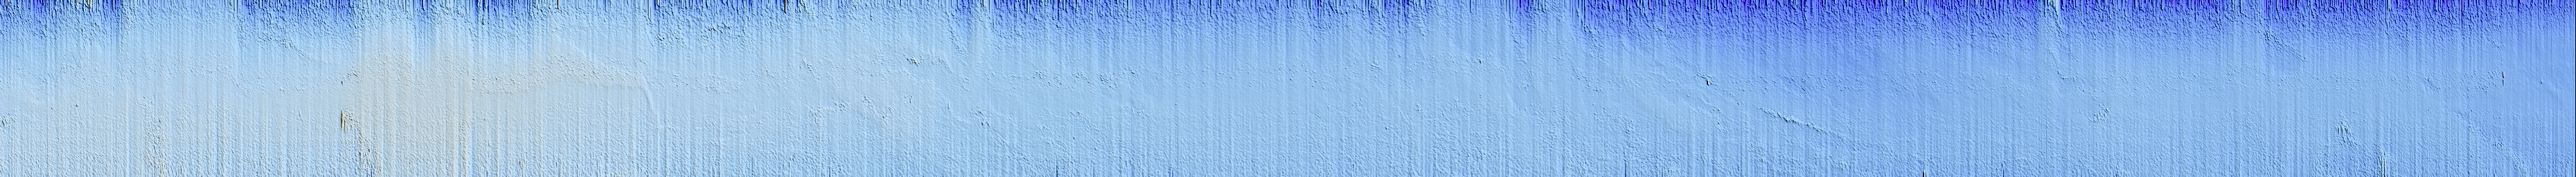

In [16]:
img.rotate(90, expand=True)

We can now close the reader

In [17]:
ems.close()

# Side scan sonar

This section reads one of the `xtf` side scan sonar files. All the files provided in this dataset have been converted to `xtf` using the NNNN tool.

This section uses the [pyxtf](https://github.com/oysstu/pyxtf) open source tool. The reader is referred to the [pyxtf github](https://github.com/oysstu/pyxtf) for more examples and explanations.

## Side scan navigation

Before reading the side scan data files, let's analyse the sensor navigation. This can be done reading the associated `side-scan-sonar-index.csv` file.

In [18]:
sss_df = pd.read_csv(data_folder/'M87/side-scan-sonar/side-scan-sonar-index.csv', sep=';', low_memory=False)

In [19]:
sss_df.head()

Data          Time  Ping Number              File   Latitude  \
0  12/08/2015  09:04:35.670          117  DATA0000106.H-PU  50.395279   
1  12/08/2015  09:04:37.010           11  DATA0000106.H-PU  50.395289   
2  12/08/2015  09:04:37.170           12  DATA0000106.H-PU  50.395289   
3  12/08/2015  09:04:37.340           13  DATA0000106.H-PU  50.395289   
4  12/08/2015  09:04:37.510           14  DATA0000106.H-PU  50.395289   

   Longitude  Heading  Roll  Pitch  SoundVelocity  PortMin  PortMean  PortMax  \
0  -7.712078   -16.07  2.27  750.0            0.0    30.35     305.0      0.0   
1  -7.712059   -16.21  2.43  750.0            0.0    30.06     251.0      0.0   
2  -7.712059   -16.21  2.43  750.0            0.0    29.85     267.0      0.0   
3  -7.712059   -16.21  2.43  750.0            0.0    30.45     254.0      0.0   
4  -7.712059   -16.21  2.43  750.0            0.0    30.91     307.0      0.0   

   StdBMin  StdBMean  StdBMax  Unnamed: 16  
0    42.54     841.0      NaN          NaN  
1    41.70     753.0      NaN          NaN  
2    42.72     395.0      NaN          NaN  
3    41.38     448.0      NaN          NaN  
4    40.70     476.0      NaN          NaN

In [20]:
sss_latitude  = sss_df['Latitude'].to_numpy(dtype=np.float32)
sss_longitude = sss_df['Longitude'].to_numpy(dtype=np.float32)

We can now plot latitude and longitude:

<IPython.core.display.Javascript object>


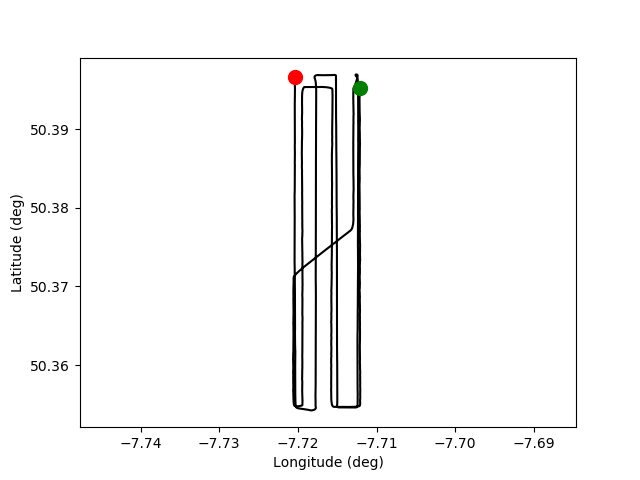

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(sss_longitude, sss_latitude, color='k')
plt.plot(sss_longitude[0], sss_latitude[0], color='g', marker='.', markersize=20)
plt.plot(sss_longitude[-2], sss_latitude[-2], color='r', marker='.', markersize=20)
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
ax.axis('equal');

### Reading xtf files

In [22]:
# Read file header and packets
sss_path = data_folder/'M87/side-scan-sonar/xtf'
sss_imgs = list(sss_path.rglob('*.xtf'))

print(f'Side scan sonar files available: {len(sss_imgs)}')

Side scan sonar files available: 1


In [23]:
idx = 0 # select the first file available

In [24]:
(fh, sss_data) = xtf_read(str(sss_imgs[idx]))

In [25]:
n_channels = fh.channel_count(verbose=True)
actual_chan_info = [fh.ChanInfo[i] for i in range(0, n_channels)]
print('Number of data channels: {}\n'.format(n_channels))

XTF Channels: sonar=2, bathy=0, snippet=0, forward=0, echo=0, interferometry=0
Number of data channels: 2



In [26]:
sonar_ch = sss_data[XTFHeaderType.sonar]  # type: List[pyxtf.XTFPingHeader]

print(f'Number of pings: {len(sonar_ch)}')

# Each element in the list is a ping (XTFPingHeader), so to retrieve the first ping:
sonar_ch_ping1 = sonar_ch[0]

# Uncomment the line below to see the properties in the header that define the attributes common for all subchannels (e.g sonar often has port/stbd subchannels)
# print(sonar_ch_ping1)

Number of pings: 4546


### Inspect the subchannels in the first sonar package

In [27]:
sonar_subchan0 = sonar_ch_ping1.data[0]  
sonar_subchan1 = sonar_ch_ping1.data[1]  

print(sonar_subchan0.shape, sonar_subchan1.shape)

(9348,) (9348,)


And we can not plot a signal-view of both subchannels of the first ping

<IPython.core.display.Javascript object>


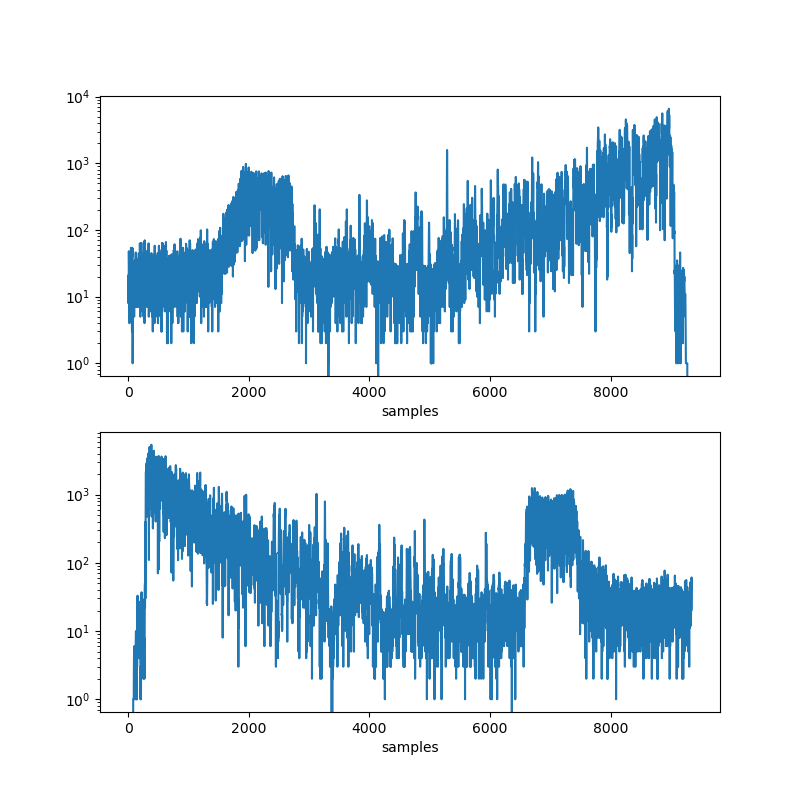

Text(0.5, 0, 'samples')

In [28]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
ax1.semilogy(np.arange(0, sonar_subchan0.shape[0]), sonar_subchan0)
ax1.set_xlabel('samples')
ax2.semilogy(np.arange(0, sonar_subchan1.shape[0]), sonar_subchan1)
ax2.set_xlabel('samples')

In [29]:
# Each subchannel has a XTFPingChanHeader, and it contains information that can change from ping to ping in each of the subchannels
sonar_ping1_ch_header0 = sonar_ch_ping1.ping_chan_headers[0]

Finally, we can now concatenate the sonar data to produce a dense array/image

In [30]:
# The function concatenate_channels concatenates all the individual pings for a channel, and returns it as a dense numpy array
np_chan1 = concatenate_channel(sss_data[XTFHeaderType.sonar], file_header=fh, channel=0, weighted=True)
np_chan2 = concatenate_channel(sss_data[XTFHeaderType.sonar], file_header=fh, channel=1, weighted=True)

# Clip to range (max cannot be used due to outliers)
# More robust methods are possible (through histograms / statistical outlier removal)
upper_limit = 2 ** 14
np_chan1.clip(0, upper_limit-1, out=np_chan1)
np_chan2.clip(0, upper_limit-1, out=np_chan2)

# The sonar data is logarithmic (dB), add small value to avoid log10(0)
np_chan1 = np.log10(np_chan1 + 0.0001)
np_chan2 = np.log10(np_chan2 + 0.0001)

# Transpose so that the largest axis is horizontal
# np_chan1 = np_chan1 if np_chan1.shape[0] < np_chan1.shape[1] else np_chan1.T
# np_chan2 = np_chan2 if np_chan2.shape[0] < np_chan2.shape[1] else np_chan2.T

and plot it:

<IPython.core.display.Javascript object>


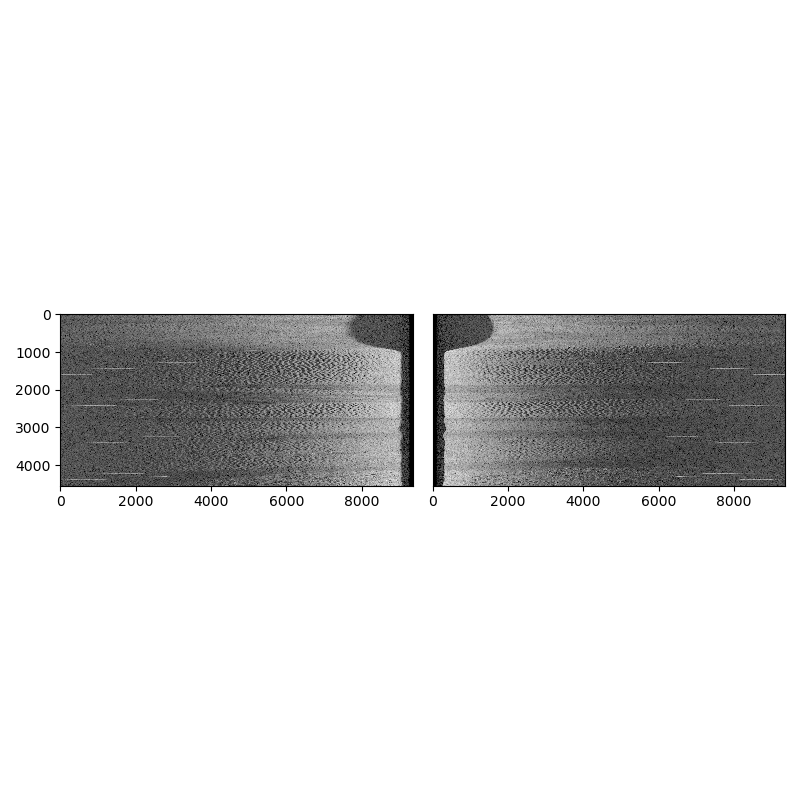

In [31]:
# The following plots the waterfall-view in separate subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), sharex=True)
ax1.imshow(np_chan1, cmap='gray', vmin=0, vmax=np.log10(upper_limit))
ax2.imshow(np_chan2, cmap='gray', vmin=0, vmax=np.log10(upper_limit))
ax2.set_yticks([])

fig.tight_layout(h_pad=0.1)

The navigation data is included in the xtf file and could be read directly from it. However, this is not possible using the open source pyxtf library.

We can however link the side scan sonar file to the vehicle navigation simply reading from the `side-scan-sonar-index.csv` file.

We have already loaded the file in a pandas dataset and we can use that to identify the correct rows:

In [32]:
sss_file = sss_df[sss_df['File'] == sss_imgs[idx].name[:-4]]

<IPython.core.display.Javascript object>


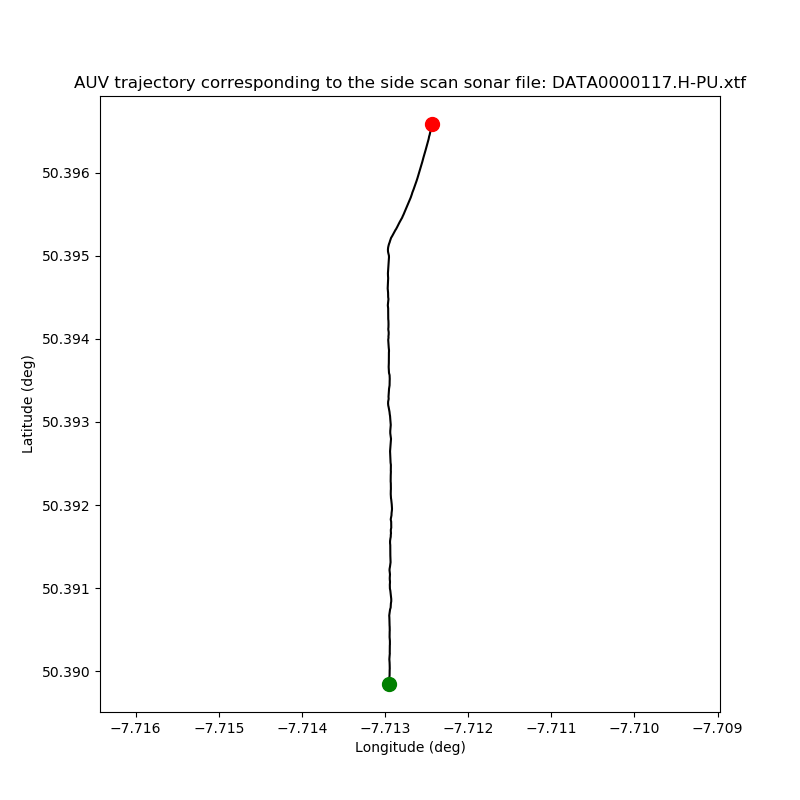

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
plt.plot(sss_file['Longitude'].to_numpy(dtype=np.float32), sss_file['Latitude'].to_numpy(dtype=np.float32), color='k')
plt.plot(sss_file['Longitude'].to_numpy(dtype=np.float32)[0], sss_file['Latitude'].to_numpy(dtype=np.float32)[0], color='g', marker='.', markersize=20)
plt.plot(sss_file['Longitude'].to_numpy(dtype=np.float32)[-2], sss_file['Latitude'].to_numpy(dtype=np.float32)[-2], color='r', marker='.', markersize=20)
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
ax.axis('equal');
ax.set_title(f'AUV trajectory corresponding to the side scan sonar file: {sss_imgs[idx].name}');

# Camera images

This section shows how to read the camera images acquired through the vertical camera of the Autosub6000.

List the camera image files:

In [34]:
camera_files = list((data_folder/r'M87/vertical-camera/raw').rglob('*.*'))

n_files = len(camera_files)
print(f'Number of image files: {n_files}')

Number of image files: 8


In [35]:
source_image = camera_files[7]
dest_image = data_folder/r'M87/vertical-camera/images/result.png'

print(f'Reading file: {source_image}')
print(f'Saving to file: {dest_image}')

Reading file: ../aurora_dataset_sample/JC125/M87/vertical-camera/raw/Test48_13331848_13083861476673.raw
Saving to file: ../aurora_dataset_sample/JC125/M87/vertical-camera/images/result.png


Let's define a simple wrapper on top of opencv functions to read the raw image and convert it to the correct color space:

In [36]:
def convertBayerToRGB(path_source, path_result, col, row):
    """
    convertBayerToRGB reads a raw image, converts it to RGB and saves it to file.
    arguments:
     - path_raw: path of the origin image
     - path_resul: path where to save the final image
     - col, row: values used to reshape the final image
    """
    
    rawimg = open(path_source,"rb")
    img = np.fromfile(rawimg, np.dtype('u1'), col * row).reshape(row, col)
    img.tofile(path_source)
    colimg = cv2.cvtColor(img, cv2.COLOR_BAYER_GB2RGBA)
    try:
        cv2.imwrite(path_result, colimg)
    except:
        cv2.imwrite(path_result.as_posix(), colimg)

We can now convert the image

In [37]:
import os

if os.name == 'nt':
    # Windows
    convertBayerToRGB(source_image.__str__(), dest_image.__str__(), col=2448, row=2048)
else:
    convertBayerToRGB(source_image, dest_image, col=2448, row=2048)

and show what we have read

<IPython.core.display.Javascript object>


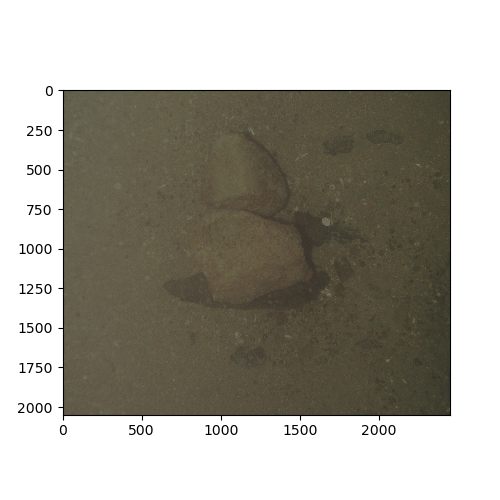

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.imshow(Image.open(dest_image))

We can now process the entire directory.

Let's create a new folder first:

In [39]:
path = pl.Path.cwd() / 'processed-images'
path.mkdir(exist_ok=True)

Run the next cell to batch process all the images.

**This might take a while!** On a i7 took ~20.7s to process 100 images.
We have hence only limited the number of images to be processed to ten. If you want to change that, comment the last cell line.

In [40]:
%%time
for idx, cfn in enumerate(camera_files):
    source_image = cfn
    dest_image = str(path/cfn.name[:-4])+'.png'
    try:
        convertBayerToRGB(source_image, dest_image, col=2448, row=2048)
    except ValueError as e:
        print(f'Error while reading: {source_image}')
    
    # Uncomment the next line if you only want to process the first 100 images.
    if idx >= 10: break

CPU times: user 1.73 s, sys: 109 ms, total: 1.84 s
Wall time: 1.82 s


Let's plot a random sample of the result:

<IPython.core.display.Javascript object>


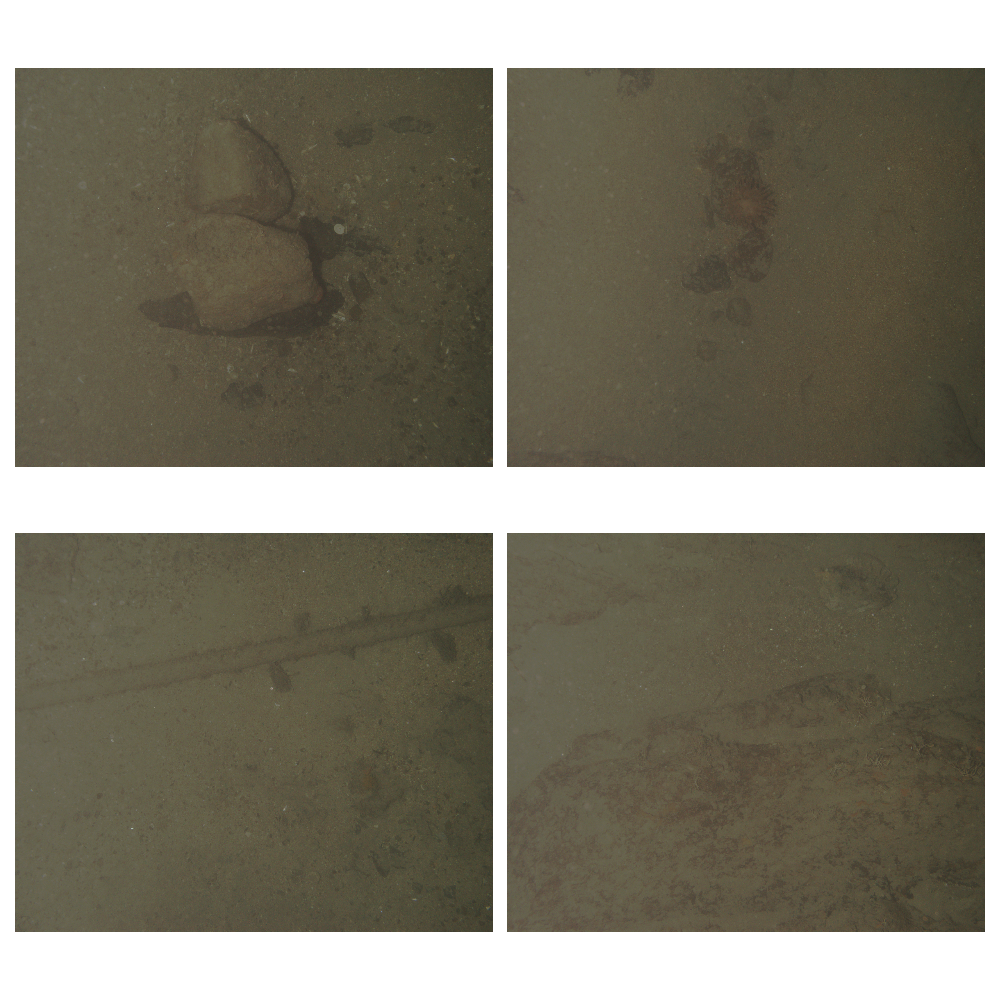

In [41]:
pimgs = list(path.rglob('*.*'))

sel_imgs = random.sample(pimgs, k=4)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

col = -1
for idx, im in enumerate(sel_imgs):
    row = idx % 2
    col = col+1 if idx % 2 == 0 else col
    ax[row][col].imshow(Image.open(im))
    ax[row][col].axis('off')
    
plt.tight_layout()

# AUV Navigation

The vehicle navigation is stored in multiple files, depending on the specific mission run.
Autosub 6000 saves its variables at 1Hz. If no new data is available, the old data is stored.

For Mission 86, the AUV variables are recorded in `multi-beam-echosounder-index.csv`.


AUV rotations are Euler angles using the yaw/pitch/roll sequence convention.

The vehicle was equipped with a ADCP to track water and ground velocities.
Each ADCP bin has its own : Inten3_Y, IntenY, VeastY, VnorthY, VdownY, VerrY where Y is the bin number. 
There are 15 bins in the ADCP configuration for this cruise.



| Variable Name | Description |
| --------------|-----------------|
|Date		    |    Date of record to nearest day (DD-Mon-YYYY) |
|Time		    |    Time of record to the nearest second (HH:MM:SS) |
|Seconds		| Seconds since first record in file |
|Latitude	(Deg)	| AUV Latitude
|Longitude	(Deg)	| AUV Longitude
|depth		(m)     | AUV Depth
|altitude	(m)     | AUV altitude above the seafloor. Values of 1000m mean out of range   |
|Roll		(rad)   |    AUV roll  |
|Pitch		(rad)   |    AUV pitch  |
|Heading		(rad) |  AUV heading |
|WaterSpeed		(m/s) |  AUV speed through the water calculated from the ADCP bins       |
|GroundSpeed	(m/s) |  AUV speed over ground determined using the DVL |
|MagX		(microTesla) |  Magnetometer raw X-value reading
|MagY		(microTesla) |  Magnetometer raw Y-value reading
|MagZ		(microTesla) |  Magnetometer raw Z-value reading
|Temperature	(oC)	|  Magnetometer temperature |
|Mspare1		|  Not used 
|Mspare2		|  Not used
|Mspare3		|  Not used
|MgB_low		|  TBC
|MgB_mid		|  TBC
|MgB_high		|  TBC
|T1		(oC) |   CTD Temperature 1
|T2		(oC) |   CTD Temperature 2
|C1		|   CTD Conductivity 1
|C2		|   CTD Conductivity 2
|Depth	(m)  | CTD depth
|DO		(V) | CTD dissolved oxygen
|LSS	(V)	| CTD Light scattering sensor
|EH		(V) | CTD EH sensor
|rho1	(Kg/m3)	| CTD, density calculated using the seabird program
|rho2	(Kg/m3)	| CTD, density calculated using the seabird program
|CorMg0		|  Correlation magnitude for bottom track
|Inten0		(0.24dB) | Beam 1 signal intensit
|Veast0		(mm/s) | Side velocity bin for bottom tracking, in the AUV frame of reference. Positive if AUV is moving to port |
|Vnorth0	(mm/s)	| Forward velocity in AUV frame. Forward motion produces a negative value for this
|Vdown0		(mm/s)  | AUV Down velocity. AUV motion down produce negative value | 
|Verr0		(mm/s) | Error velocity
|ADCPVersion		|  Version number
|ADCPRev		|  Revision number
|HeadBias		(0.01 Deg) | Always 0
|NumWatPings		|  Number of water pings per ensemble. Always 1.
|CellSize		(cm) | ADCP cell size in cm. (e.g. 800) |
|BlankSize		(cm) | ADCP blanking period in cm |
|NumCells		| ADCP number of water track cells
|MinThresh		|
|HeadAlign		(0.01 Deg) | Heading align (critical to navigation) | 
|Salinity		(PSU) |  Fixed salinity for ADCP sound velocity correction (e.g. 35).
|SoundSpeed		(m/sec) | Speed of Sound that the ADCP calculates at zero depth (T and S correction only)
|ADCPTemp		(oC) | Temperature measured at the ADCP head
|Inten3_Y		(0.24dB)|  Beam 3 signal intensity. 
|IntenY	(0.24dB) | Beam Y signal intensity
|VeastY		(mm/s) | Side velocity bin Y. In AUV frame of reference. If AUV is moving to port, then this number is positive.
|VnorthY	(mm/s) | Forward velocity in AUV frame. Forward motion produces a negative value for this
|Vdown1		(mm/s) | ADCP down velocity. AUV motion down produce negative values.
|VerrY		(mm/s) | ADCP Error velocity

In [42]:
auv_data_df = pd.read_csv(data_folder/'M86/multi-beam-echosounder-index.csv', sep=',', low_memory=False)

In [43]:
auv_data_df.head()

Date         Time     Seconds           Latitude        Longitude  \
0  10-Aug-2015     16:30:00         -7958        50.333973        -7.711981   
1  10-Aug-2015     16:30:02         -7956        50.333973        -7.711983   
2  10-Aug-2015     16:30:04         -7954        50.333973        -7.711986   
3  10-Aug-2015     16:30:06         -7952        50.333973        -7.711987   
4  10-Aug-2015     16:30:08         -7950        50.333973        -7.711989   

             depth         altitude             Roll            Pitch  \
0        -0.421316      1000.000000         0.063879        -0.016162   
1        -0.421316      1000.000000         0.031870        -0.023911   
2        -0.384176      1000.000000        -0.006109        -0.010786   
3        -0.421316      1000.000000         0.000227         0.009634   
4        -0.384464      1000.000000         0.037332         0.008186   

           Heading  ...          Veast14         Vnorth14          Vdown14  \
0         0.083112  ...              NaN              NaN              NaN   
1         0.073164  ...              NaN              NaN              NaN   
2         0.067317  ...              NaN              NaN              NaN   
3         0.078348  ...              NaN              NaN              NaN   
4         0.092066  ...              NaN              NaN              NaN   

            Verr14        Inten3_15          Inten15          Veast15  \
0              NaN              NaN              NaN              NaN   
1              NaN         0.000000        41.000000              NaN   
2              NaN         0.000000        41.000000              NaN   
3              NaN         0.000000        41.000000              NaN   
4              NaN         0.000000        41.000000              NaN   

          Vnorth15          Vdown15           Verr15  
0              NaN              NaN              NaN  
1              NaN              NaN              NaN  
2              NaN              NaN              NaN  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN  

[5 rows x 140 columns]

Some cells have additonal blanks and this might make pandas not able to import them correctly. To remove them:

In [44]:
auv_data_df.columns = auv_data_df.columns.str.replace(' ','')

In [45]:
auv_latitude  = auv_data_df['Latitude'].to_numpy(dtype=np.float32)
auv_longitude = auv_data_df['Longitude'].to_numpy(dtype=np.float32)

We can now plot the AUV longitude and latitude. We also plot, the deployment point of the vehicle (in green) and its recovery point (in red)

<IPython.core.display.Javascript object>


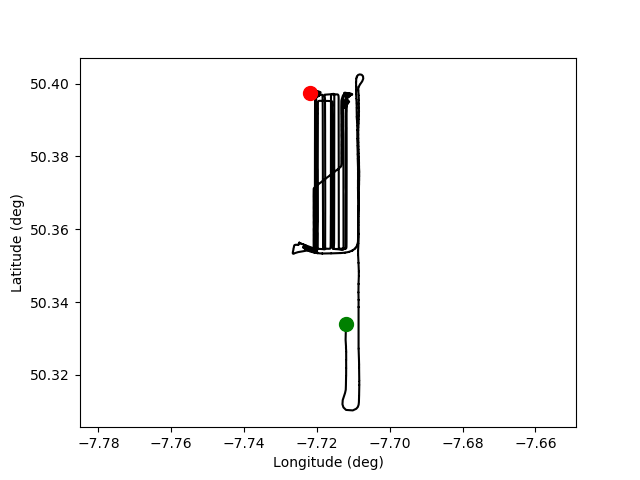

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(auv_longitude, auv_latitude, color='k')
plt.plot(auv_longitude[0], auv_latitude[0], color='g', marker='.', markersize=20)
plt.plot(auv_longitude[-2], auv_latitude[-2], color='r', marker='.', markersize=20)
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
ax.axis('equal');

To show the trajectory on the map, we need to convert them into a list. We also decimate them with a factor of 50, since we do not to be extremly precise for this.

In [47]:
auv_path = []
for lat, lon in zip(auv_latitude[0:-2:50], auv_longitude[0:-2:50]):    
    auv_path.append([lat, lon])    

In [48]:
auv_line = Polyline(
    locations=auv_path,
    color="black" ,
    fill=False,
    name="auv_mbes_path",
)
m.center = auv_path[0]

m.add_layer(auv_line)

In [49]:
m

Map(center=[50.333973, -7.711981], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

### AUV attitude

In [50]:
auv_pitch = auv_data_df['Pitch'].to_numpy(dtype=np.float32)
auv_roll  = auv_data_df['Roll'].to_numpy(dtype=np.float32)
auv_heading  = auv_data_df['Heading'].to_numpy(dtype=np.float32)

In [51]:
auv_pitch, auv_roll, auv_heading

(array([-0.016162, -0.023911, -0.010786, ..., -0.023405, -0.013282,
              nan], dtype=float32),
 array([ 0.063879,  0.03187 , -0.006109, ..., -0.00075 ,  0.005794,
              nan], dtype=float32),
 array([0.083112, 0.073164, 0.067317, ..., 2.520664, 2.318015,      nan],
       dtype=float32))

<IPython.core.display.Javascript object>


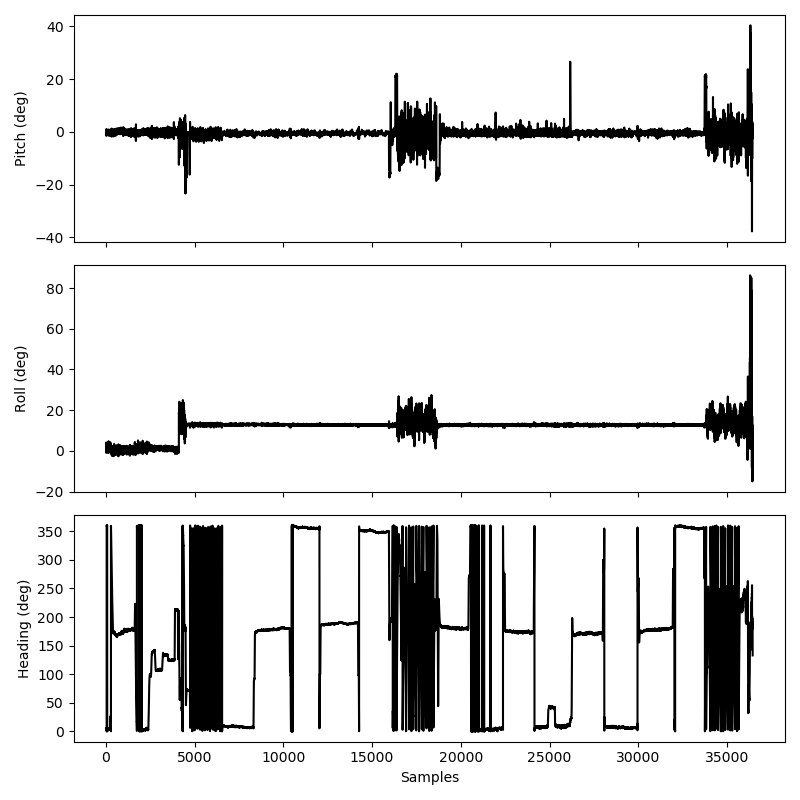

In [52]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,8), sharex=True)

ax[0].plot(auv_pitch*180/3.14, color='k')
ax[0].set_ylabel('Pitch (deg)');

ax[1].plot(auv_roll*180/3.14, color='k')
ax[1].set_ylabel('Roll (deg)');

ax[2].plot(auv_heading*180/3.14, color='k')
ax[2].set_ylabel('Heading (deg)');
ax[2].set_xlabel('Samples');

plt.tight_layout()

### AUV Ground Speed and Water Speed

In [53]:
auv_gv = auv_data_df['GroundSpeed'].to_numpy(dtype=np.float32)
auv_wv  = auv_data_df['WaterSpeed'].to_numpy(dtype=np.float32)

<IPython.core.display.Javascript object>


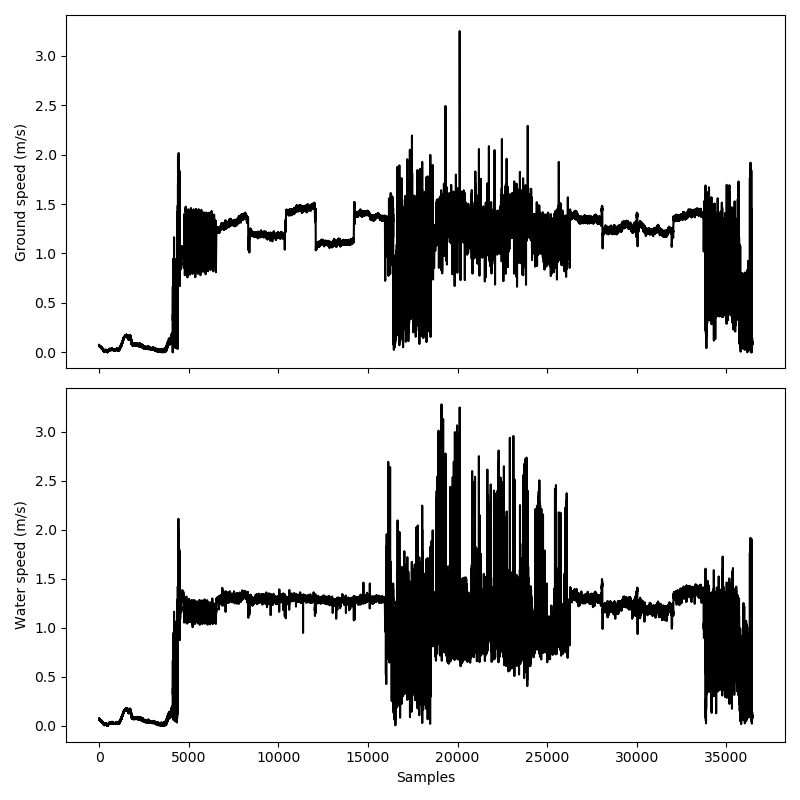

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8), sharex=True)

ax[0].plot(auv_gv, color='k')
ax[0].set_ylabel('Ground speed (m/s)');

ax[1].plot(auv_wv, color='k')
ax[1].set_ylabel('Water speed (m/s)')
ax[1].set_xlabel('Samples')

plt.tight_layout();

# fin.